# part0: imports

In [6]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")
from IPython.display import clear_output
from scipy.stats import pearsonr

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection
from matplotlib.backends.backend_pdf import PdfPages


import torch

import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.mouse_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(params)
    reload (defs)
finally:
    os.chdir(nbPath)

print('Done')

Done


# reading data

In [2]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root / animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_pull_mouse(df)
    AllDFs.append(df)

clear_output()

---

# CCA comparison

## 2 mice, same epoch

load the data

In [3]:
# load the DFs
warnings.filterwarnings("ignore")
allDFs_M1 = []
for df in AllDFs:
    if 'M1_rates' in df.columns:
        allDFs_M1.append(df)


allDFs_Str = []
for df in AllDFs:
    if 'Str_rates' in df.columns:
        allDFs_Str.append(df)
warnings.filterwarnings("default")


pairFileList1 = []
for I, df1 in enumerate(allDFs_M1):
    for J, (df2) in enumerate(allDFs_M1):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList1.append((I,J))

print(f'{len(pairFileList1)=}')


pairFileList2 = []
for I, df1 in enumerate(allDFs_Str):
    for J, df2 in enumerate(allDFs_Str):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList2.append((I,J))

print(f'{len(pairFileList2)=}')


len(pairFileList1)=13
len(pairFileList2)=13


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

In [4]:
def plot_mouse_cca(ax, allDFs_M1):
    defs = params.mouse_defs
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, defs.exec_epoch_pull, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, defs.exec_epoch_pull, area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # upper bound
    AllData1 = dt.get_data_array(allDFs_M1, defs.exec_epoch_pull, area=defs.areas[0], model=defs.n_components)
    print(f'{AllData1.shape=}')
    n_iter = params.n_iter * 10
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for sessionData in AllData1:
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # lower bound
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, df2 in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    len_trial = int(np.round(np.diff(defs.WINDOW_exec_pull)/defs.BIN_SIZE))

    AllData1 = dt.get_data_array(side1df, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            time_idx = params.rng.integers(min_time-len_trial)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T


    #====================================PLOTTING
    
    x_ = np.arange(1,defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    ax.text(x=defs.n_components, y=1, s= f'$n={CCsL.shape[1]}$ pairs of sessions\nacross $4$ mice',
            ha='right', va='top', fontsize=mpl.rcParams['xtick.labelsize'])



AllData1.shape=(6, 4, 7, 12, 10)


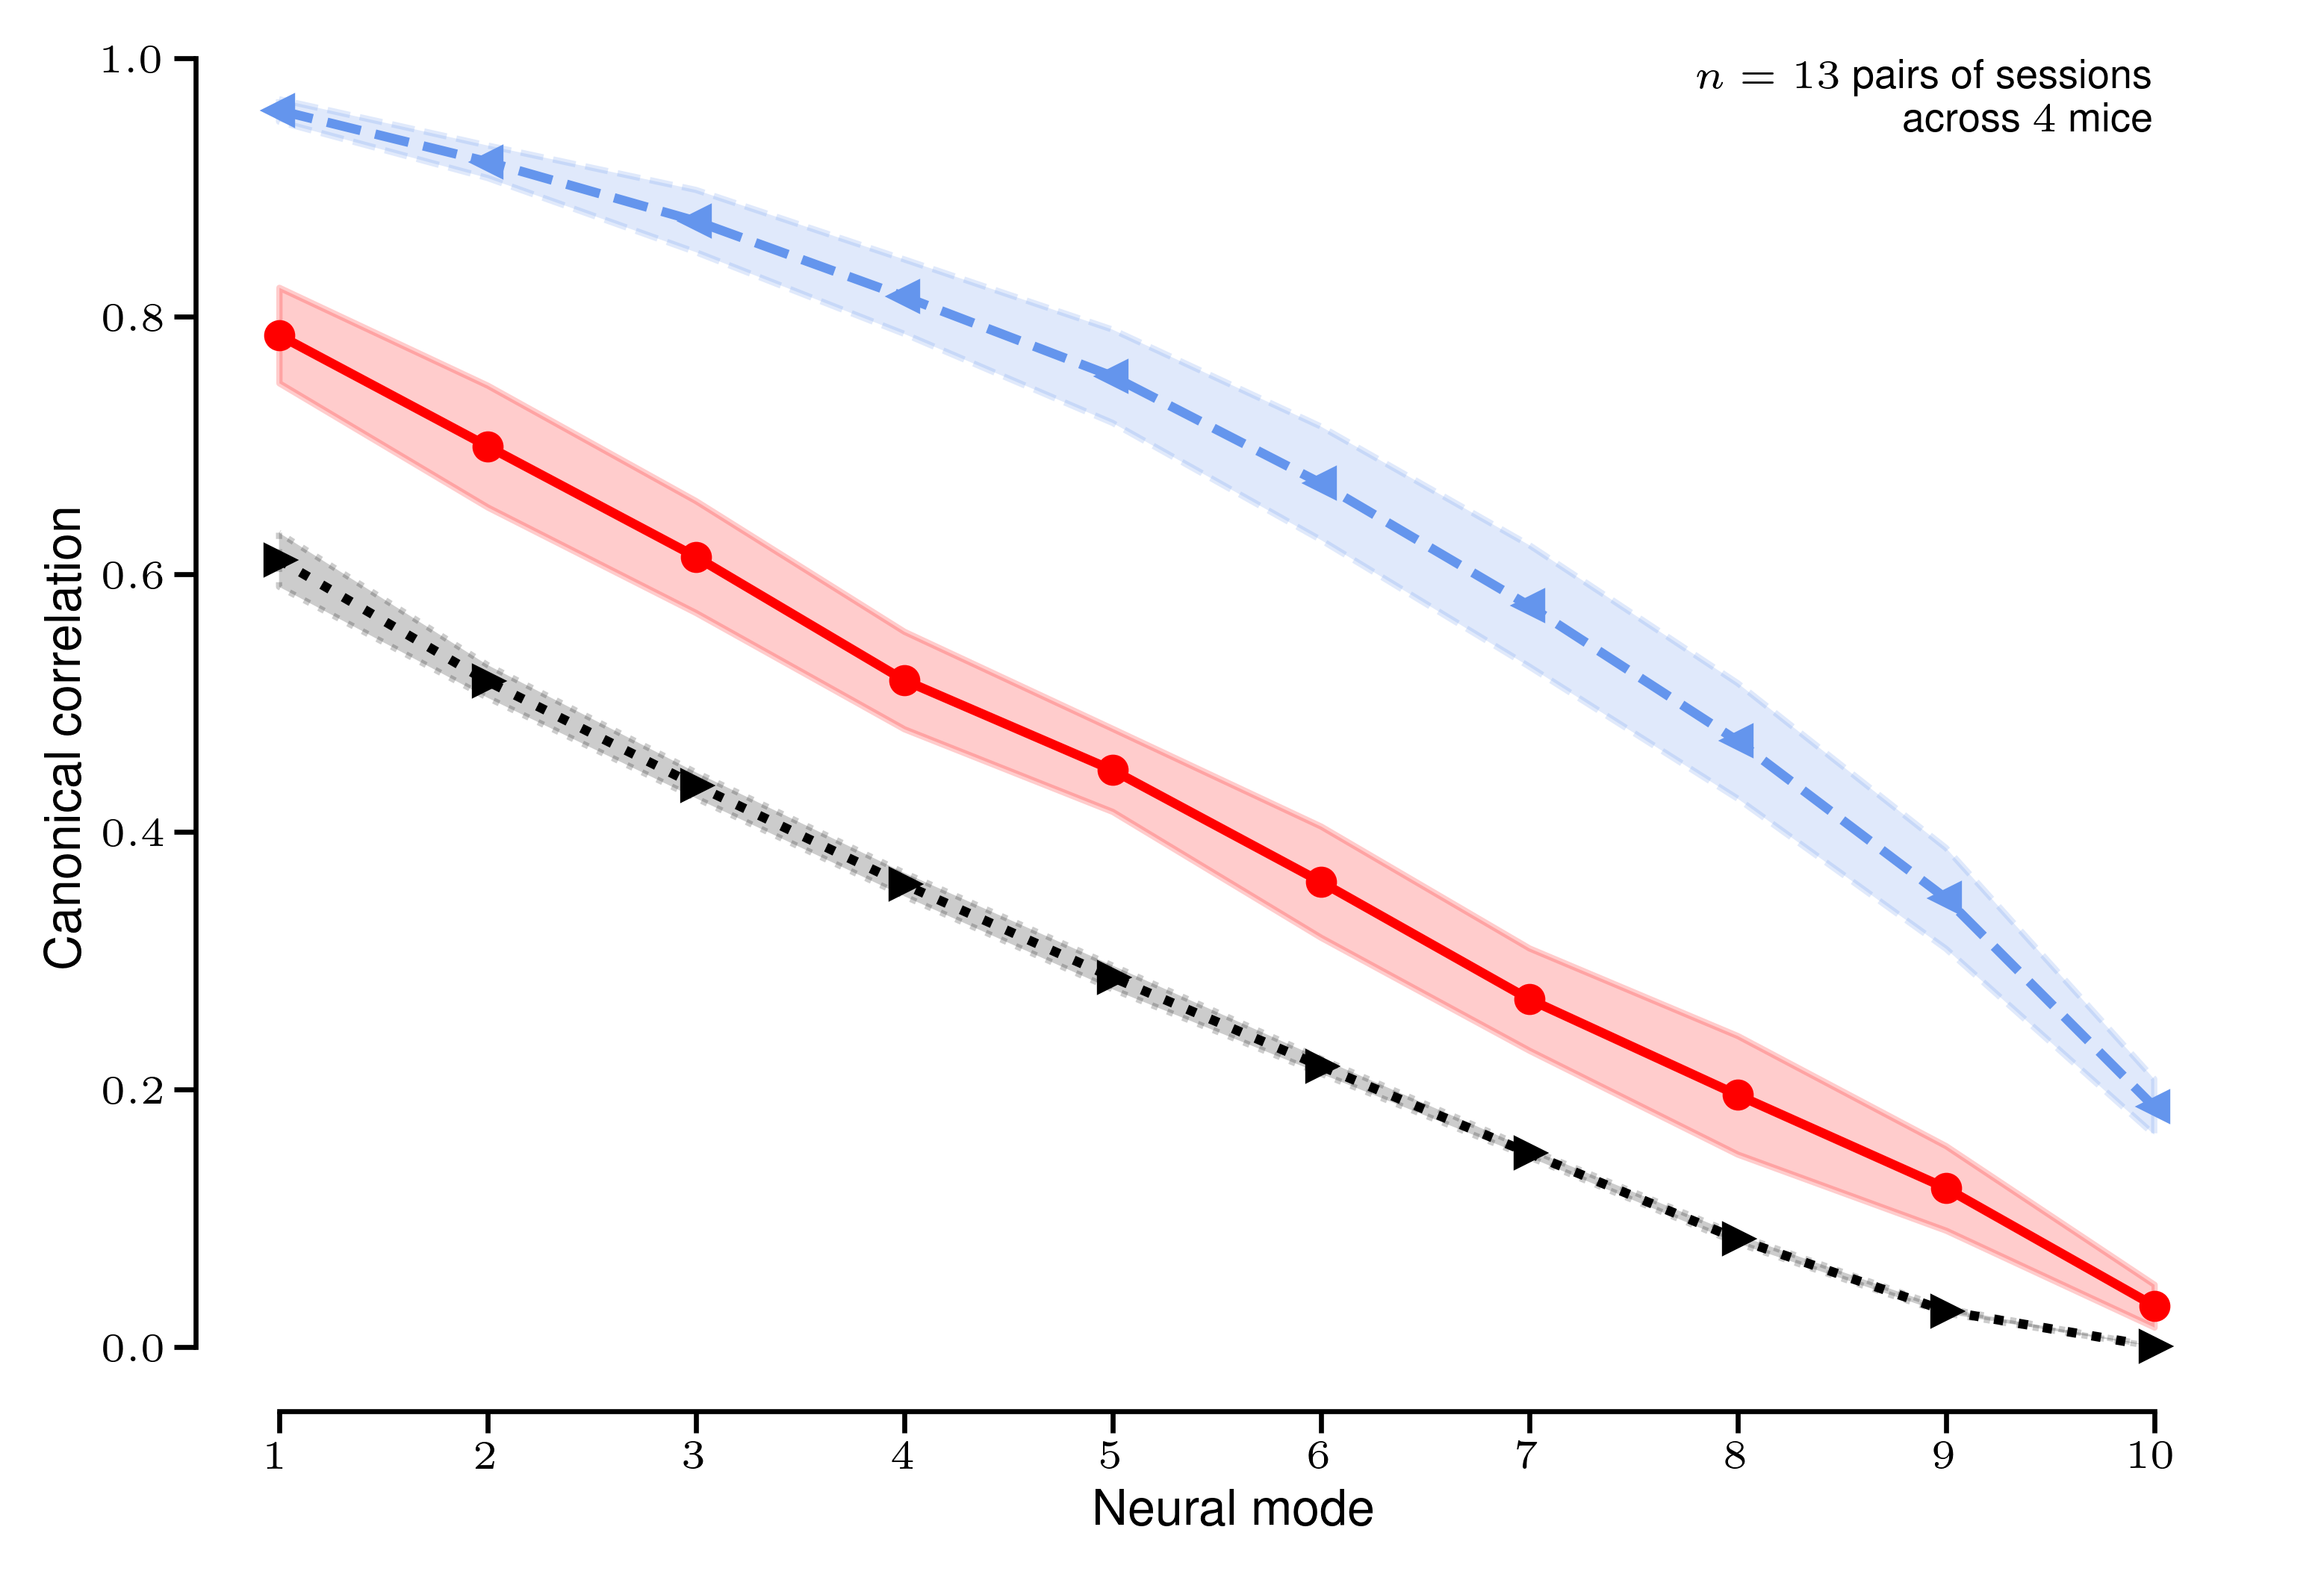

In [7]:
plot_mouse_cca(plt.gca(), allDFs_M1)
plt.savefig('/home/msafaie/cca-pull.pdf')

## CCA vs Behavioural correlation

In [33]:
def del_nan(a,b):
    a_bad = np.isnan(a)
    b_bad = np.isnan(b)
    bad = np.logical_or(a_bad,b_bad)
    good = np.logical_not(bad)
    
    return a[good], b[good]

def trim_across_mouse_corr(allDF:list[pd.DataFrame],):
    trim_across_corrs = {}
    across_good = across_bad = 0
    for dfi, df1__ in enumerate(allDF):
        df1 = pyal.restrict_to_interval(df1__, epoch_fun=defs.exec_epoch_pull)
        targets = np.unique(df1.target_id)
        trim_across_corrs[df1.file[0]]={}
        for dfj, df2__ in enumerate(allDF):
            df2 = pyal.restrict_to_interval(df2__, epoch_fun=defs.exec_epoch_pull)
            trim_across_corrs[df2.file[0]] = {} if df2.file[0] not in trim_across_corrs.keys() else trim_across_corrs[df2.file[0]]
            if dfj <= dfi: continue
            trim_across_corrs[df1.file[0]][df2.file[0]]=[]
            for target in targets:
                df1_ = pyal.select_trials(df1, df1.target_id == target)
                df2_ = pyal.select_trials(df2, df2.target_id == target)
                for i, vel1 in enumerate(df1_.hTrjB):
                    for j, vel2 in enumerate(df2_.hTrjB):
                        r = []
                        data_pairs = [(del_nan(aa,bb)) for aa,bb in zip(vel1.T,vel2.T)]
                        for d1, d2 in data_pairs:
                            try:
                                r.append(pearsonr(d1, d2)[0])
                            except:
                                across_bad += 1
                        trim_across_corrs[df1_.file[0]][df2_.file[0]].append(np.mean(np.abs(r)))
            print(f'{dfi=}, {dfj=}, bad={across_bad}')
            across_bad =0

        # make the across correlations symmetrical!
        for  df2_file, val in trim_across_corrs[df1_.file[0]].items():
            trim_across_corrs[df2_file][df1_.file[0]] = val
    return trim_across_corrs

def plot_mouse_cca_corr(ax, AllDFs):
    mouse_defs = defs
        
    across_corrs_mice = trim_across_mouse_corr (AllDFs)
    
    pairFileList_mice = []
    for I, df1 in enumerate(AllDFs):
        for J, (df2) in enumerate(AllDFs):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList_mice.append((I,J))

    side1df = [AllDFs[i] for i,_ in pairFileList_mice]
    side2df = [AllDFs[j] for _,j in pairFileList_mice]
    AllData1_mice = dt.get_data_array(side1df, mouse_defs.exec_epoch_pull, area=mouse_defs.areas[0], model=mouse_defs.n_components)
    AllData2_mice = dt.get_data_array(side2df, mouse_defs.exec_epoch_pull, area=mouse_defs.areas[0], model=mouse_defs.n_components)
    _,_, min_trials_mice, min_time_mice,_ = np.min((AllData1_mice.shape,AllData2_mice.shape),axis=0)

    CC_corr_mice=[]
    for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_mice,AllData2_mice)):
        data1 = np.reshape(sessionData1[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
        k,l = pairFileList_mice[i]
        behav = np.array(across_corrs_mice[AllDFs[k].file[0]][AllDFs[l].file[0]])
        behav = behav[behav>params.Behav_corr_TH]
        CC_corr_mice.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
    CC_corr_mice = np.array(CC_corr_mice)

    #plotting
    ax.scatter(CC_corr_mice[:,1],CC_corr_mice[:,0],color=params.colors.MousePts, label='Mice', zorder=1)
    
    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Canonical correlation')
    ax.set_ylim([.53,.85])
    ax.spines['left'].set_bounds([.55,.85])
    ax.set_xlim([.69,.95])
    ax.spines['bottom'].set_bounds([.7,.95])
    ax.legend(loc=(0,.8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.2f$'))


dfi=0, dfj=1, bad=0
dfi=0, dfj=2, bad=0
dfi=0, dfj=3, bad=0
dfi=0, dfj=4, bad=60
dfi=0, dfj=5, bad=0
dfi=1, dfj=2, bad=0
dfi=1, dfj=3, bad=0
dfi=1, dfj=4, bad=60
dfi=1, dfj=5, bad=0
dfi=2, dfj=3, bad=0
dfi=2, dfj=4, bad=69
dfi=2, dfj=5, bad=0
dfi=3, dfj=4, bad=30
dfi=3, dfj=5, bad=0
dfi=4, dfj=5, bad=78


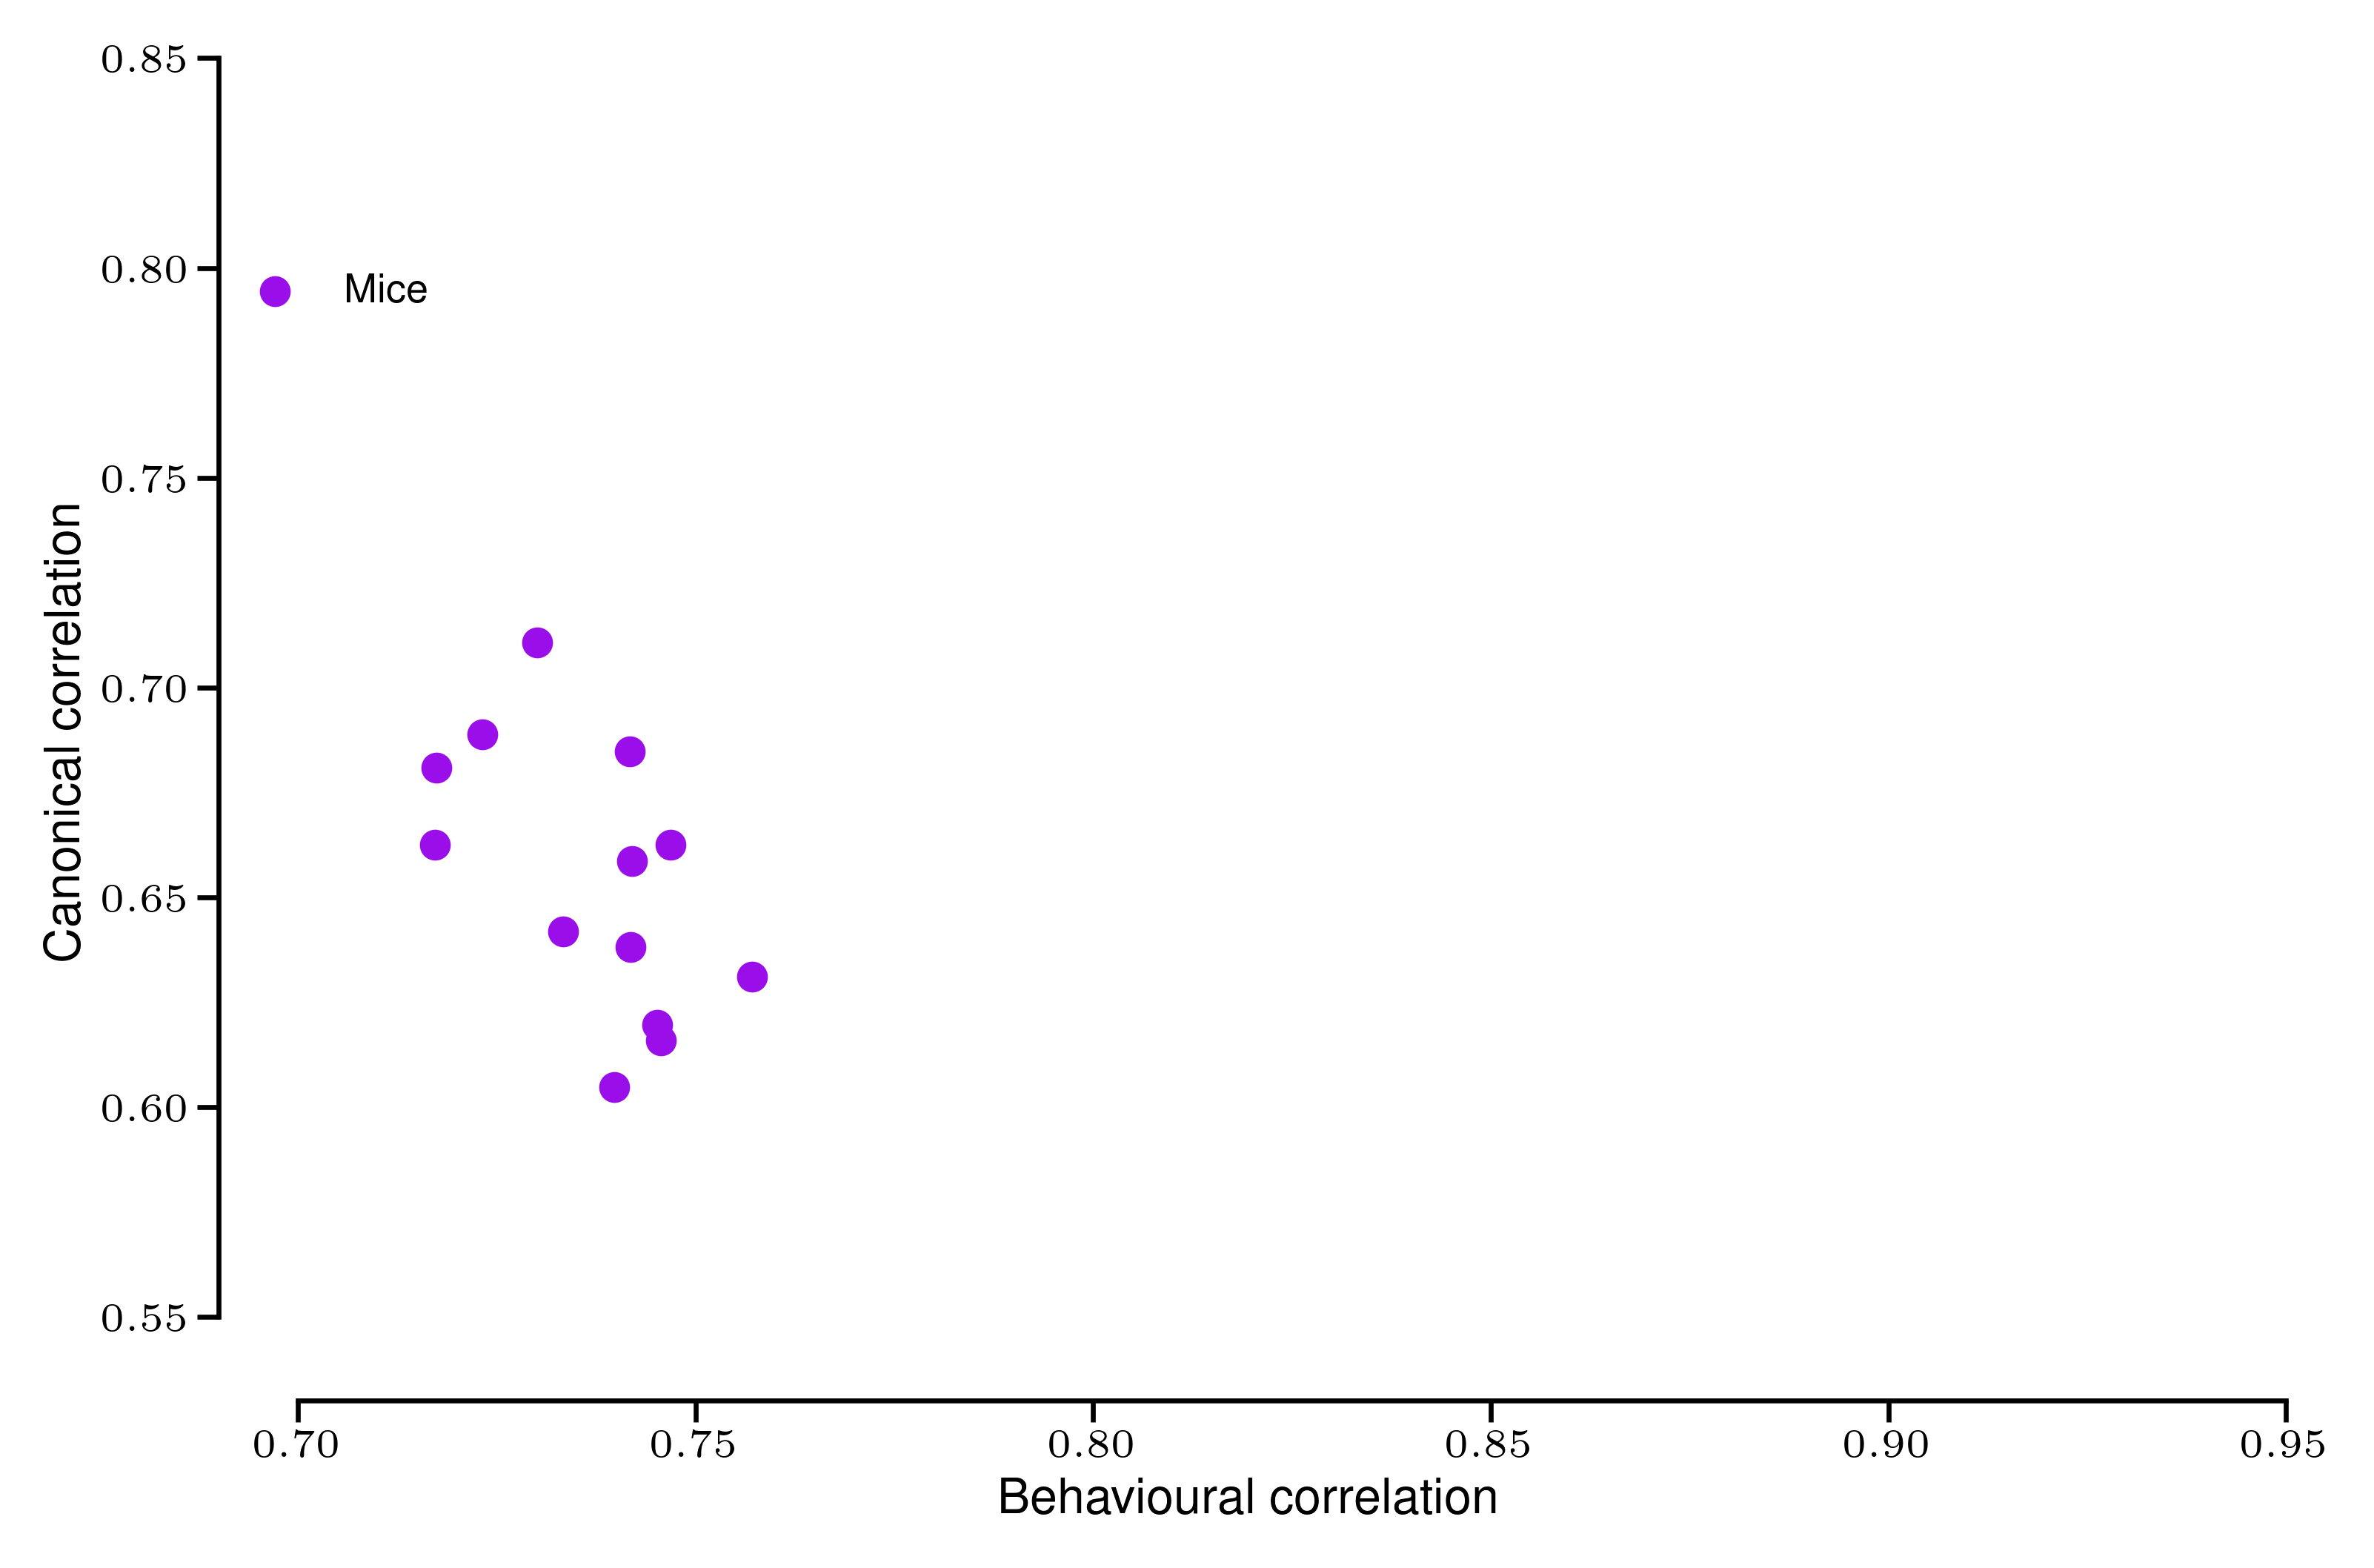

In [34]:
plt.close('all')
set_rc()
fig,ax = plt.subplots(1,1)
plot_mouse_cca_corr(ax, allDFs_M1)
# fig.savefig('/home/msafaie/cca-pull-behav.pdf')
